In [46]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from model import ode_y, ode_y_jump_approach_one, ode_y_jump_approach_one_boundary
from utilities import find_nearest_value
from numba import njit

import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

**ODE for y on (0, 2)**:
\begin{align*}
0 = \max_{\tilde{e}} \min_h &  -\delta \phi(y) + \delta \eta \log \tilde{e} \\
&+ \frac{d\phi(y)}{dy}\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h) + \frac{1}{2} \frac{d^2 \phi(y)}{(d y)^2}|\sigma_y|^2(\tilde{e})^2\\
&+ (\eta-1)(\gamma_1 + \gamma_2 y)\tilde{e}(\sum_{i=1}^n \pi_i^c \theta_i\ + \sigma_y \cdot h)\\
& +\frac{\xi_{1,m}}{2}h^\prime h + \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
& + \mathcal{I}(y) \sum_{j=1}^m \hat{\pi}_j^d g_j [\phi_j(y)-\phi(y)] + \xi_{2,m} \mathcal{I}(y)\sum_{j=1}^m \hat{\pi}_j^d \left[1- g_j + g_j \log g_j\right]
\end{align*}

where
$$
\mathcal{I}(y) = \frac{1}{\sqrt{2\pi}\varsigma}\exp\{-\frac{(\bar{y}-y)^2}{2\varsigma^2}\}
$$

The FOC of $h$ gives:
$$
h^* = -\frac{\left(\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y )\right)\tilde{e}\sigma_y}{\xi_{1,m}}
$$


Substitute $h$ with $h^*$ in the ODE:

\begin{align*}
0 = \max_{\tilde{e}} & -\delta \phi(y) + \delta \eta \log \tilde{e} \\
& + G(y)\tilde{e}\sum_{i=1}^n \pi^c_i\theta_i + \frac{1}{2} \left(\frac{d^2 \phi(y)}{(d y)^2}-\frac{G^2(y)}{\xi_{1,m}}\right)|\sigma_y|^2(\tilde{e})^2\\
&+ \xi_a\sum_{i=1}^{n} \pi_i^c(\log \pi_i^c - \log \hat{\pi}_i^c)\\
& + \mathcal{I}(y) \sum_{j=1}^m \hat{\pi}_j^d g_j [\phi_j(y)-\phi(y)] + \xi_{2,m} \mathcal{I}(y)\sum_{j=1}^m \hat{\pi}_j^d \left[1- g_j + g_j \log g_j\right]
\end{align*}

where $G(y):=\frac{d\phi(y)}{dy} + (\eta-1)(\gamma_1 + \gamma_2 y)$

The FOC of $\tilde{e}$ gives:
$$
\tilde{e}^* = \frac{-\sum_{i=1}^n\pi^c_i \theta_i G(y) + \sqrt{\left(\sum_{i=1}^n \pi_i^c \theta_i\right)^2G^2(y)-4\delta \eta |\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_m}\right)}}{2|\sigma_y|^2\left(\frac{d^2\phi(y)}{(dy)^2}-\frac{G^2(y)}{\xi_{1,m}}\right)}
$$

In addition, the FOC of $\pi^c_i$ gives:
$$
\pi_i^c \propto \exp \left[-\frac{1}{\xi_a}G(y)\tilde{e}\theta_i\right]\hat{\pi}^c_i
$$

The FOC of $g_j$ gives:
$$
g_j = \exp \left(-\frac{1}{\xi_m}[\phi_j(y)-\phi(y)]\right)
$$

In [61]:
ξ_1m = 1./400
ξ_a = 1000

η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*1.86/1000

y_bar = 2.
γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = np.array([0, .0197*2])
πd_o = np.array([.5, .5])
# γ_2p = np.array([0, .0197*2, .3853*2])
# πd_o = np.array([.475, .475, .05])

y_step = .02
y_grid_long = np.arange(0., 4., y_step)
y_grid_short = np.arange(0., 2+y_step, y_step)
n_bar = find_nearest_value(y_grid_long, y_bar) + 1

In [62]:
# Prepare ϕ
ϕ_list = []
for γ_2p_i in γ_2p:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_a, γ_1, γ_2, γ_2p_i, y_bar) 
    model_res = ode_y(y_grid_long, model_paras, v0=None, ϵ=.5,
                       tol=1e-8, max_iter=10_000, print_all=False)
    ϕ_list.append(model_res['v0'])

ϕ_list_short = []
for ϕ_i in ϕ_list:
    temp = ϕ_i[:n_bar]
    ϕ_list_short.append(temp)
ϕ_i = np.array(ϕ_list_short)

Converged. Total iteration 10000: LHS Error: 1.453751923313762e-06; RHS Error 7.880238624667375e-07
Converged. Total iteration 2068: LHS Error: 9.956630513119347e-09; RHS Error 4.406953638417079e-06


In [51]:
# Compute ϕ
ς = .25
ξ_2m = ξ_1m*5
model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                    ϵ=.5, tol=1e-9, max_iter=10000, print_all=False)

In [52]:
# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

In [63]:
def simulation(y_grid, e_grid, θ=1.86/1000., y_start=.5394, T=100):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
        if y_start > 100:
            print(i)
    return Et, yt


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [54]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [64]:
# Compute ϕ
ς = .25
ξ_2m_list = [1000., ξ_1m*20, ξ_1m*5]
Et_list = []
for ξ_2m in ξ_2m_list:
    model_paras = (η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, ς, γ_1, γ_2, y_bar, ϕ_i, πd_o)
    model_res = ode_y_jump_approach_one_boundary(y_grid_short, model_paras, v0=np.average(ϕ_i, weights=πd_o, axis=0),
                                                        ϵ=.5, tol=1e-9, max_iter=10000, print_all=False)

    Et, yt = simulation(y_grid_short, model_res['e_tilde'], θ=np.mean(θ), y_start=.5394, T=100)
    Et_list.append(Et)

Converged. Total iteration 418: LHS Error: 9.8237375179e-10; RHS Error 3.4457485679813423e-06
Converged. Total iteration 493: LHS Error: 9.965807484801914e-10; RHS Error 3.888378481539201e-06
Converged. Total iteration 663: LHS Error: 9.202564196786334e-10; RHS Error 3.768303337048427e-06


In [65]:
SCCt_neutral = η*(0.025)*Kt/((1.-η)*Et_list[0]) * 1000
SCCt_x20 = η*(0.025)*Kt/((1.-η)*Et_list[1]) * 1000
SCCt_x5 = η*(0.025)*Kt/((1.-η)*Et_list[2]) * 1000

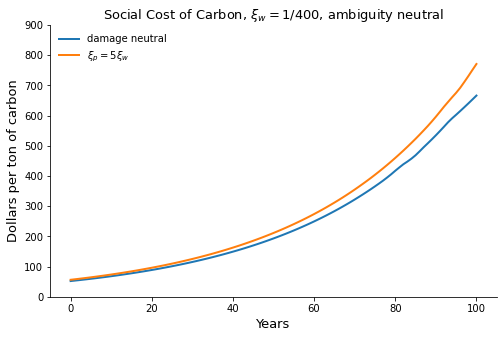

In [66]:
plt.figure(figsize=(8, 5))
plt.plot(SCCt_neutral, label='damage neutral', linewidth=2.)
plt.plot(SCCt_x5, label=r'$\xi_p = 5\xi_w$', linewidth=2.)
plt.ylim(0, 900)
plt.xlabel('Years', fontsize=13)
plt.ylabel('Dollars per ton of carbon', fontsize=13)
plt.legend(frameon=False)
plt.title(r'Social Cost of Carbon, $\xi_w=1/400$, ambiguity neutral', fontsize=13)
plt.savefig('scc.pdf')